In [1]:
#자기가 사용하는 gpu 할당
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=7


In [2]:
import torch

import torch.nn.functional as F

from loader import get_dataloader
from train import run
from models import PointNet, PointCNN

In [3]:
epochs=200
b_size=8
lr=0.001
lr_decay=0.5
lr_decay_step=50
weight_decay=0
num_class = 10 #
name = '{}'.format(num_class)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

train_loader, test_loader = get_dataloader(1024, b_size)
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
print(torch.cuda.get_device_name(device))

Available devices  1
Current cuda device  0
GeForce RTX 2080 Ti


In [5]:
#Train
model = PointCNN(num_class)
# run(train_loader, test_loader, model, epochs, b_size, lr,
#     lr_decay, lr_decay_step, weight_decay, device)

In [6]:
#load pretrained
from train import test
PATH = "saves/"+model._get_name() +".pth"
model.load_state_dict(torch.load(PATH))
model.eval()

#test the loaded model
model = model.to(device)
test_acc = test(model,test_loader, device)
print ("test acc: {:.04f}".format(test_acc))

test acc: 0.9306


In [7]:
test_dataset = test_loader.dataset

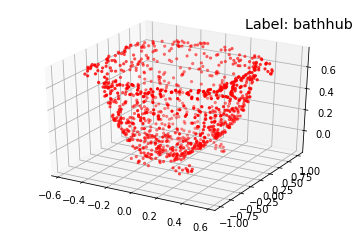

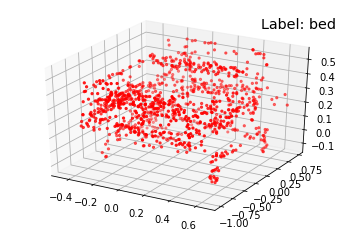

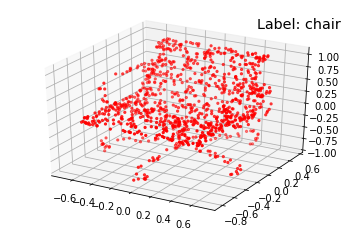

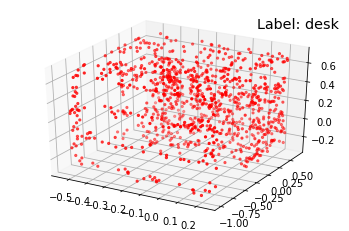

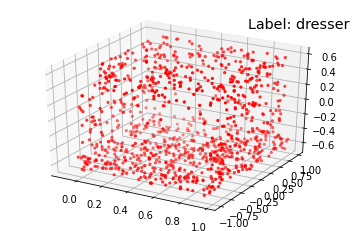

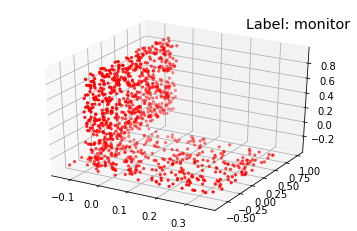

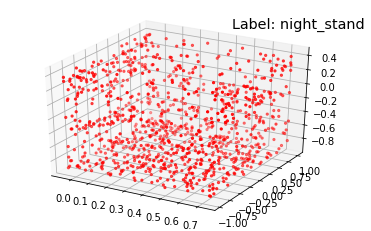

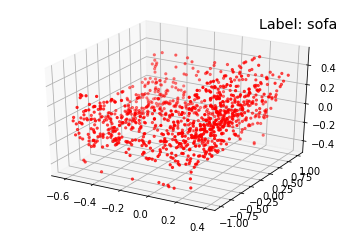

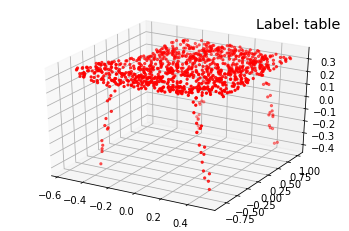

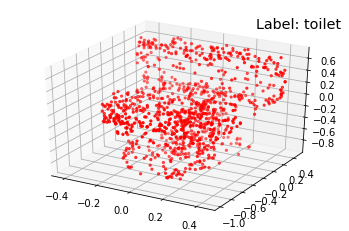

In [8]:
from utils import visualize

check=[]

for data in test_dataset:
    if data.y.item() not in check:
        pos = data.pos
        label = data.y.item()
        visualize(pos,label)
        check.append(data.y.item())

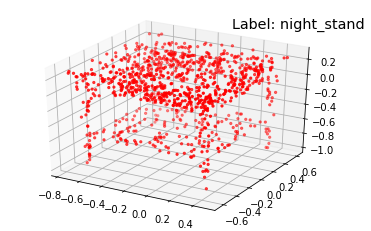

expected label : 8, answer label : 6


In [126]:
idx=525
data=test_dataset[idx]
visualize(data.pos, data.y.item())
data=data.to(device)
pos = data.pos
score = model(pos, torch.zeros(1024, dtype=torch.long).to(device))
print("expected label : {}, answer label : {}".format(torch.argmax(score).item(), data.y.item()))


In [127]:
idxs = [0,68,180,445, 525, 750, 810]
labels= ["bathhub", "bed", "chair","mornitor", "night stand","table", "toilet"]

In [128]:
from attack import fgsm_attack
import torch.nn.functional as F

pos.requires_grad = True
score = model(pos, torch.zeros(1024, dtype=torch.long).to(device))
loss = F.nll_loss(score, torch.tensor([6],dtype=torch.long).cuda())
# Zero all existing gradients
model.zero_grad()
# Calculate gradients of model in backward pass
loss.backward()
# Collect datagrad
data_grad = pos.grad.data

epsilons=[0,0.05,0.10,0.15,0.2,0.25,0.3]
perturbed_pos=[]
for epsilon in epsilons:
    temp = []
    for idx in idxs:
        data=test_dataset[idx]
        data=data.to(device)
        pos = data.pos
        temp.append(fgsm_attack(pos, epsilon, data_grad))
    perturbed_pos.append(temp)

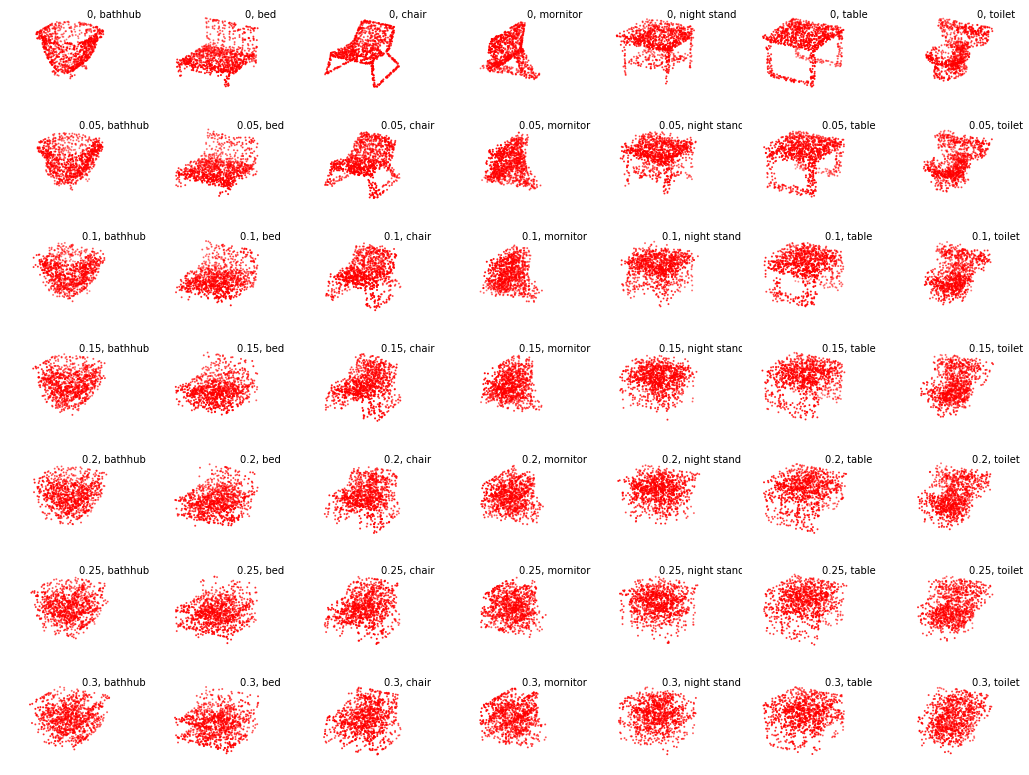

In [156]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(18, 14))
cnt = 1
for i in range(7):
    for j in range(7):
#     for j in range(len(perturbed_pos)):
        ax = fig.add_subplot(7,7,cnt, projection='3d')
        cnt+=1
        ax.text2D(0.87, 0.92, '{}, {}'.format(
        epsilons[i],labels[j]), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        pos = perturbed_pos[i][j].cpu().detach()
        ax.set_axis_off()
        ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], color='red', s=1)
        
#         orig,adv,ex = examples[i][j]
#         plt.title("{} -> {}".format(orig, adv))
        
plt.show()